# Synopsis

The number of bonds between two atoms is an interresting feature to play with but is not provided with the competition data.

This kernel builds a dataset with the reconstructed bonding scheme for each molecule.  
The algorithm used to do so is to build a spanning tree conecting each atom of the molecule. 
Connection are made based on the expecting bonding distance for each pair of nearby atoms.

The [Output Dataset](https://www.kaggle.com/asauve/predicting-molecular-properties-bonds) will be updated following bond detction improvements. 
It is built with the same keys as for the competition tables `structure` and `train`/`test`.

Tables `train_bonds` and `test_bonds` have one row per bond :
```
molecule_name | atom_index_0 | atom_index_1 | nbond | error | bond_type
```
* `nbond` is the number of covalent bonds between `atom_index_0` (relative to `structure`) and `atom_index_1`
* `error` is `0` if the molecule has a  consistent reconstruction (meaning that each atom has the expected number ofcovalent bonds). 
Otherwise it is set to `1` for each bond of the molecule
* `bond_type` is <nbond><atom0><atom1>. Atom appear in lexicographic order to ensure unicity for 2 atoms combination.   
    Example: `1CH`, `2CC`

Less than 3% of molecules in each dataset failed to build a consistent bond set. 
This page and the dataset will be updated when I can figure out how to manage these cases.
Potential failure causes are:
* Bad cycle connection due to ordering of bond building
* Different number of covalent bonds than the usual case. For example Oxygen can form 3 bonds in some cases, but I still need a method to detect efficiently these cases.


# General information

![](https://storage.googleapis.com/kaggle-competitions/kaggle/14313/logos/thumb76_76.png?t=2019-05-16-16-56-19)

This kernel uses data from [Predicting Molecular Properties](https://www.kaggle.com/c/champs-scalar-coupling) which is intended to predict interactions between atoms in the domain of Nuclar Magnetic Resonnance (NMR). More precisely it is the *scalar coupling constant* between atoms which is to be predicted.

As this challenge is based uppon molecular topological properties, it can be useful to have an appropriate way of representing molecules.
These visualizations can then be used to infer useful hints to understand the coupling properties, engineer appropriate features and debug
prediction failures.



# Others Work

* [Is type related to scalar coupling? EDA](https://www.kaggle.com/hrmello/is-type-related-to-scalar-coupling)  
"ALL 1JHC couplings are above 60."
* [Competition metric](https://www.kaggle.com/abhishek/competition-metric)
* [Molecular Properties EDA and models](https://www.kaggle.com/artgor/molecular-properties-eda-and-models)   
this kernel scores 0.626 and uses features `dist_speedup` which is atoms relative distance calculated with L2 norm
* [Exploring Molecular Properties Data](https://www.kaggle.com/robikscube/exploring-molecular-properties-data)   
propose a nice exploratory work on extraneous features in the train dataset
* [How To: Easy Visualization of Molecules.](https://www.kaggle.com/borisdee/how-to-easy-visualization-of-molecules/comments)  
Boris shows in  this kernel hos to use the Ase library for mouse movable molecular display (no bond type support)

# Load data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from ase import Atoms
import ase.visualize

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
print("Modules loading Done!")

Modules loading Done!


In [3]:
csv_files = [ "train.csv", "test.csv", "structures.csv" ]
csv_vars  = [ filename[:-4] for filename in csv_files ]
for filename, var in zip( csv_files, csv_vars ):
    eval_str = f"{var:32s} = pd.read_csv('../input/{filename}')"
    print(eval_str)
    exec(eval_str)
    print(f"{'nb of cols ':32s}= "+str(eval(f"len({var})")))
    exec(f"display({var}.head())")


train                            = pd.read_csv('../input/train.csv')
nb of cols                      = 4658147


id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant  
0                   84.8076  
1                  -11.2570  
2                  -11.2548  
3                  -11.2543  
4                   84.8074

test                             = pd.read_csv('../input/test.csv')
nb of cols                      = 2505542


id     molecule_name  atom_index_0  atom_index_1  type
0  4658147  dsgdb9nsd_000004             2             0  2JHC
1  4658148  dsgdb9nsd_000004             2             1  1JHC
2  4658149  dsgdb9nsd_000004             2             3  3JHH
3  4658150  dsgdb9nsd_000004             3             0  1JHC
4  4658151  dsgdb9nsd_000004             3             1  2JHC

structures                       = pd.read_csv('../input/structures.csv')
nb of cols                      = 2358657


molecule_name  atom_index atom         x         y         z
0  dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001
1  dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976
2  dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277
3  dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644
4  dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397

# Molecule display code

The following code snipet (unhide to see) is taken from [Training set molecule visualization](https://www.kaggle.com/asauve/training-set-molecule-visualization). 
It builds a 3D molecule visualization with 
* scalar_coupling_constant as transparent connections: thickness is a factor of scalar value
  * plain for 1J spin-spin coupling
  * dashed for 2J
  * dotted for 3J
* covalent bonds are drawn as black lines: thickness increase with number of bonds

In [4]:
cpk = { 
    'C': ("black", 2),
    'H': ("white", 1),
    'O': ("red",   2),
    'N': ("blue", 2),
    'F': ("green", 2) }
def plot_molecule(name, ax=None, bonds=None, elev=0, azim=-60):
    """bonds = if provided add bonds display from the bond table dataset in https://www.kaggle.com/asauve/predicting-molecular-properties-bonds
    elev = 3D elevation angle [degree] for the molecule view
    azim = 3D azimut angle [degree]
    """
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    if (elev != 0) or (azim != -60):
        ax.view_init(elev=elev, azim=azim)
    
    # atoms location
    m = structures[structures.molecule_name == name]
    
    # formula
    acount = {a : 0 for a in cpk}
    for a in m.atom:
        acount[a] += 1
    formula = ""
    for a in acount:
        if acount[a] == 1:
            formula += a
        elif acount[a] > 1:
            formula += "%s_{%d}" % (a, acount[a])

    ax.set_title(f'{name} ${formula}$')
    
    # display couplings (coupling is not molecular bonds!)
    couples = train[train.molecule_name == name][['atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
    for c in couples.itertuples():
        m0 = m[m.atom_index == c.atom_index_0]
        m1 = m[m.atom_index == c.atom_index_1]
        ax.plot([float(m0.x), float(m1.x)],[float(m0.y), float(m1.y)],[float(m0.z), float(m1.z)],
               linestyle = ['', '-', '--', 'dotted'][int(c.type[0])],
               color     = ['', 'black', 'green', 'red' ][int(c.type[0])],
               linewidth = abs(float(c.scalar_coupling_constant))/5,
               alpha=0.2), 
    if bonds is not None:
        for b in bonds[bonds.molecule_name == name].itertuples():
            m0 = m[m.atom_index == b.atom_index_0]
            m1 = m[m.atom_index == b.atom_index_1]
            ax.plot([float(m0.x), float(m1.x)],[float(m0.y), float(m1.y)],[float(m0.z), float(m1.z)], 'black', 
                    linewidth=2*float(b.nbond),
                    color=['', 'black', 'green', 'red'][int(b.bond_type[0])])
            
    # display atoms
    ax.scatter(m.x, m.y, m.z, c=[cpk[a][0] for a in m.atom], s=[100*cpk[a][1] for a in m.atom], edgecolor='black')
    
    # display atom index
    for row in m.itertuples():
        ax.text(float(row.x) - 0.15, float(row.y) - 0.15, float(row.z) - 0.15, str(row.atom_index), color='darkviolet')

This example shows the three kind of coupling types. The 1 bond coupling having the largest coupling constant.

# Bonds reconstruction algorithm

Useful links :
* <a href="https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page)">Atomic radii of the elements</a>

The algorithm for bond selection is
* Select a molecule
* **STEP 1** : 1-bond connect   
 For each atom
    * For each #VALENCE closest match:
        * does the distance correspond to the expected bond distance?
            * does both atoms have remaining bonds?
              * decease remaining valence and create bond
              * mark both atoms as leaf if one of them has zero remaining valence
* **STEP 2** : n-bond greedy connect   
While there are remaining leafs atoms with available valence
    * For each connected neighbour 
      * add as many bonds as possible
      * mark both connected atoms as leaf
* **CHECK**   
Has any atom remaining valence > 0?
    * mark the molecule with error=1
  

In [6]:
from scipy.spatial import cKDTree as KDTree
from tqdm import tqdm_notebook as tqdm


# "usual" valence of atoms
VALENCE = { 'C': 4, 'H' : 1, 'N' : 3, 'O' : 2, 'F': 1 }

# expected distances in [A] for covalence 1 bond
BOND_DIST_C1 = { 'C' : 0.77, 'H' : 0.38, 'N' : 0.75, 'O' : 0.73, 'F' : 0.71 }

# order used for finding bonds by atom type
BOND_ORDER = { 'H' : 0, 'F' : 0, 'O' : 1, 'N' : 2, 'C' : 3}

def add_bond(n_avail, nbond, a0, a1, d1=None):
    key = tuple(sorted((a0, a1)))
    if key in nbond:
        nbond[key][0] += 1
    elif d1 is not None:
        nbond[key] = [1, d1]
    else:
        raise Exception(f"{a0},{a1} added after phase 1")
    n_avail[a0] -= 1
    n_avail[a1] -= 1
    #display(f"{a0},{a1} => {n_avail}, {nbond}")

def compute_bonds(structures, molecules):
    out_name = []; out_a0 = []; out_a1 = []; out_n = []; out_dist = []; out_error = []
    for imol,name in tqdm(enumerate(molecules)):
        molecule = structures.loc[name ]
        error    = 0
        atoms    = molecule.atom.values
        
        n_avail  = np.asarray([VALENCE[a] for a in atoms])
        leaf     = np.zeros(len(atoms), dtype=np.bool) # is the atom at the end of connection tree?
        coords   = molecule[['x', 'y', 'z']].values
        kdt = KDTree(coords) # use an optimized structure for closest match query
        nbond = {}
        connected = { a:{} for a in np.arange(len(atoms))}
        
        # select Hydrogen first to avoid butadyne-like ordering failures (molecule_name=dsgdb9nsd_000023)
        ordered_atoms_index = list(range(len(atoms)))
        ordered_atoms_index.sort(key = lambda i: BOND_ORDER[atoms[i]])
        
        # STEP 1: 1-bond connect each atom with closest match
        for a0 in ordered_atoms_index:
            atom0 = atoms[a0]
            if n_avail[a0] == 0:
                continue
            next_dist, next_i = kdt.query(coords[a0], min(1+VALENCE[atom0], len(atoms)))
            next_dist = next_dist[1:]; # remove a0 from list
            next_i = next_i[1:]
            
            # for each #VALENCE closest atoms
            for d1,a1 in zip(next_dist, next_i):
                if a1 in connected[a0]: # enforce 1-bound only in STEP 1
                    continue
                atom1 = atoms[a1]
                predicted_bond = BOND_DIST_C1[atom0] + BOND_DIST_C1[atom1]
                if abs(d1 / predicted_bond) < 1.2: # keep only atoms in the 20% expected distance or closer
                    if n_avail[a1] > 0:
                        add_bond(n_avail, nbond, a0, a1, d1)
                        connected[a0][a1] = 1
                        connected[a1][a0] = 1
                        if (n_avail[a0] == 0) or (n_avail[a1] == 0):
                            leaf[a0] = 1
                            leaf[a1] = 1
                else:
                    #print(f"-- match failure in molecule_name={name} {a0}:{atom0}-{a1}:{atoms[a1]}={d1} predicted={predicted_bond}")
                    pass
        
        # STEP 2: greedy connect n-bonds, progressing from leafs of connection tree
        while (((n_avail > 0).sum() > 0) and leaf).sum() > 0:
            progress = False
            for a0 in np.arange(len(atoms))[((n_avail > 0).sum() > 0) and leaf]:
                for a1 in connected[a0]:
                    if (n_avail[a0] > 0) and (n_avail[a1] > 0):
                        add_bond(n_avail, nbond, a0, a1) 
                        progress = True
                        if (n_avail[a0] == 0) or (n_avail[a1] == 0):
                            leaf[a0] = 1
                            leaf[a1] = 1
            if not progress:
                break
        
        if n_avail.sum() > 0:
            for key in nbond.keys():
                a0, a1 = key
                while (n_avail[a0] > 0) and (n_avail[a1] > 0):
                    add_bond(n_avail, nbond, a0, a1)
           
        if n_avail.sum() > 0:
            # display info on failed molecules
            error = 1
            print(f"   Remaining links={n_avail.sum()//2} for molecule_name={name}, link: a0={a0}:{atom0} a1={a1}:{atoms[a1]}")
            #print(f"{n_avail.sum()} bonds remaining for {imol}:{name}")
            #display(molecule)
            #display(nbond)
        
        for (a0, a1), (n, dist) in nbond.items():
            # append to python lists which is 7x faster than toa pd.DataFrame
            out_name.append(name); out_a0.append(a0); out_a1.append(a1); out_n.append(n)
            out_dist.append(dist); out_error.append(error)
        
    bonds = pd.DataFrame({'molecule_name':out_name, 'atom_index_0':out_a0,'atom_index_1':out_a1, 'nbond':out_n, 
                          'L2dist':out_dist, 'error':out_error})
    return bonds
            


# Build bonds for train / test sets

In [7]:
train_bonds = compute_bonds(structures.set_index('molecule_name'), train.molecule_name.unique())

   Remaining links=1 for molecule_name=dsgdb9nsd_000202, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000271, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000731, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000761, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000840, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000842, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000854, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000855, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000910, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000912, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000982, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_001006, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_001007, link: a0=2:C a1=3:C

   Remaining links=1 for molecule_name=dsgdb9nsd_005050, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005051, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005052, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005053, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005054, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005056, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005146, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005150, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005159, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005164, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005165, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005177, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_005184, link: a0=3:C a1=4:C

   Remaining links=1 for molecule_name=dsgdb9nsd_016191, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_016397, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_017808, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_018099, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_018305, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_018306, link: a0=4:C a1=5:C
   Remaining links=2 for molecule_name=dsgdb9nsd_018308, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_018651, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_018653, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_018654, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_018655, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_019025, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_019026, link: a0=5:C a1=6:C

   Remaining links=1 for molecule_name=dsgdb9nsd_021969, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_021970, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_021972, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_021974, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_021976, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_021978, link: a0=3:C a1=7:C
   Remaining links=2 for molecule_name=dsgdb9nsd_021980, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_021981, link: a0=5:C a1=6:N
   Remaining links=1 for molecule_name=dsgdb9nsd_021985, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_021991, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_021992, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_022007, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_022009, link: a0=4:C a1=5:C

   Remaining links=1 for molecule_name=dsgdb9nsd_024544, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024584, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024594, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024595, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024610, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024681, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024682, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024723, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024734, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024736, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024739, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024742, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024744, link: a0=4:C a1=5:C

   Remaining links=1 for molecule_name=dsgdb9nsd_025668, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025669, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025682, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025686, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025709, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025711, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025727, link: a0=2:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025730, link: a0=2:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025732, link: a0=8:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025765, link: a0=2:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025773, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025774, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025776, link: a0=5:C a1=7:C

   Remaining links=1 for molecule_name=dsgdb9nsd_026843, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026865, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026871, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026881, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026884, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026887, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026912, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026915, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026990, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026992, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026994, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026996, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026998, link: a0=4:C a1=5:C

   Remaining links=1 for molecule_name=dsgdb9nsd_027708, link: a0=2:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027709, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027730, link: a0=2:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027745, link: a0=2:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027756, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027762, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027774, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027778, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027794, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027812, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027813, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027832, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027856, link: a0=2:C a1=3:C

   Remaining links=1 for molecule_name=dsgdb9nsd_029382, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029384, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029388, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029390, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029394, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029396, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029402, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029406, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029408, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029410, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029412, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029414, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_029416, link: a0=1:C a1=2:C

   Remaining links=1 for molecule_name=dsgdb9nsd_030651, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030652, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030661, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030662, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030663, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030664, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030669, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030670, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030689, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030699, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030701, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030761, link: a0=9:C a1=10:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030766, link: a0=3:C a1=4:

   Remaining links=1 for molecule_name=dsgdb9nsd_031907, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031908, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031909, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031910, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031933, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031934, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031939, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031940, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031941, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031974, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031978, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031979, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_031980, link: a0=4:C a1=5:C

   Remaining links=1 for molecule_name=dsgdb9nsd_033306, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_033310, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_033400, link: a0=5:C a1=10:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034474, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034477, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034478, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034483, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034486, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034489, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034492, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034497, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034523, link: a0=4:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034532, link: a0=5:C a1=6:

   Remaining links=1 for molecule_name=dsgdb9nsd_043409, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_043411, link: a0=6:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_043412, link: a0=6:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_043413, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_043418, link: a0=6:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_043419, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_043423, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_043425, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_043437, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_044525, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_045297, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_045298, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_045538, link: a0=7:C a1=8:C

   Remaining links=1 for molecule_name=dsgdb9nsd_074241, link: a0=4:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_074243, link: a0=4:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_075170, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_075418, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_075733, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_075734, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_075735, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_075740, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_075741, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_075742, link: a0=6:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_075746, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_076135, link: a0=8:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_076136, link: a0=8:C a1=9:C

   Remaining links=1 for molecule_name=dsgdb9nsd_102015, link: a0=7:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_102794, link: a0=5:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_102796, link: a0=5:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_103579, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_103584, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_103813, link: a0=8:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_105215, link: a0=6:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_106909, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_106914, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_108844, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_108846, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_109419, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_109421, link: a0=6:C a1=7:C

   Remaining links=1 for molecule_name=dsgdb9nsd_123912, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123915, link: a0=0:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123927, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123949, link: a0=0:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123967, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123978, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123991, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_124000, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_124003, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_124004, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_124006, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_124009, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_124013, link: a0=7:C a1=8:C

   Remaining links=1 for molecule_name=dsgdb9nsd_125393, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125630, link: a0=0:C a1=1:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125655, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125659, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125732, link: a0=6:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125734, link: a0=6:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125785, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125804, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125805, link: a0=0:C a1=1:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125857, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125860, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125871, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125873, link: a0=4:C a1=5:C

   Remaining links=1 for molecule_name=dsgdb9nsd_127826, link: a0=2:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_127844, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_127879, link: a0=2:C a1=8:N
   Remaining links=1 for molecule_name=dsgdb9nsd_127949, link: a0=6:C a1=8:N
   Remaining links=1 for molecule_name=dsgdb9nsd_127953, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_127955, link: a0=2:C a1=8:N
   Remaining links=1 for molecule_name=dsgdb9nsd_127956, link: a0=2:C a1=8:N
   Remaining links=1 for molecule_name=dsgdb9nsd_128020, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128022, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128024, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128026, link: a0=6:C a1=7:N
   Remaining links=1 for molecule_name=dsgdb9nsd_128037, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128042, link: a0=6:C a1=7:N

   Remaining links=1 for molecule_name=dsgdb9nsd_129625, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129627, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129644, link: a0=2:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129646, link: a0=2:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129664, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129677, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129683, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129695, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129696, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129697, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129704, link: a0=2:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129706, link: a0=2:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129720, link: a0=1:C a1=2:C

   Remaining links=1 for molecule_name=dsgdb9nsd_131223, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131235, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131241, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131244, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131245, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131374, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131437, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131438, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131448, link: a0=1:C a1=8:N
   Remaining links=1 for molecule_name=dsgdb9nsd_131484, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131516, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131527, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131537, link: a0=6:C a1=8:C

   Remaining links=1 for molecule_name=dsgdb9nsd_132116, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132119, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132121, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132124, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132145, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132146, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132159, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132171, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132182, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132183, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132201, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132202, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_132209, link: a0=5:C a1=6:C

In [8]:
test_bonds  = compute_bonds(structures.set_index('molecule_name'), test.molecule_name.unique())

   Remaining links=1 for molecule_name=dsgdb9nsd_000204, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000206, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000208, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000210, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000211, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000282, link: a0=1:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000724, link: a0=0:C a1=5:N
   Remaining links=1 for molecule_name=dsgdb9nsd_000733, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000763, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000782, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000843, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000909, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_000911, link: a0=5:C a1=6:C

   Remaining links=1 for molecule_name=dsgdb9nsd_006683, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_007335, link: a0=5:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_007602, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_007657, link: a0=6:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_007909, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_007913, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_007914, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_007918, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_008398, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_010016, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_011382, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_011384, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_012586, link: a0=5:C a1=6:C

   Remaining links=1 for molecule_name=dsgdb9nsd_024126, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024137, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024143, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024179, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024181, link: a0=0:C a1=1:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024189, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024191, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024193, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024237, link: a0=4:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024239, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024244, link: a0=4:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024245, link: a0=4:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_024254, link: a0=4:C a1=5:C

   Remaining links=1 for molecule_name=dsgdb9nsd_025949, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025955, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025973, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_025993, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026016, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026066, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026071, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026077, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026079, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026097, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026156, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026162, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_026164, link: a0=3:C a1=4:C

   Remaining links=1 for molecule_name=dsgdb9nsd_027776, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027780, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027811, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027834, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027837, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027844, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027868, link: a0=2:C a1=3:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027953, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027961, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027972, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_027989, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_028015, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_028043, link: a0=5:C a1=6:C

   Remaining links=1 for molecule_name=dsgdb9nsd_030532, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030540, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030547, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030552, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030556, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030562, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030563, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030565, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030576, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030577, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030600, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030604, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_030645, link: a0=6:C a1=7:C

   Remaining links=1 for molecule_name=dsgdb9nsd_033192, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_033220, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_033221, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_033241, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_033251, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034475, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034538, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034572, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034584, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034620, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034645, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_034666, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_035648, link: a0=4:C a1=7:C

   Remaining links=1 for molecule_name=dsgdb9nsd_054538, link: a0=9:C a1=10:C
   Remaining links=1 for molecule_name=dsgdb9nsd_054582, link: a0=9:C a1=10:C
   Remaining links=1 for molecule_name=dsgdb9nsd_054615, link: a0=2:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_054766, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_054795, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_054900, link: a0=10:C a1=11:C
   Remaining links=1 for molecule_name=dsgdb9nsd_055145, link: a0=5:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_055146, link: a0=8:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_055400, link: a0=3:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_055611, link: a0=6:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_055621, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_057736, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_058614, link: a0=6:C a1

   Remaining links=1 for molecule_name=dsgdb9nsd_115195, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_115699, link: a0=8:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_120427, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_120430, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_120433, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_121596, link: a0=6:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_121613, link: a0=4:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_121864, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123129, link: a0=8:C a1=9:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123274, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123294, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123303, link: a0=4:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_123330, link: a0=7:C a1=8:C

   Remaining links=1 for molecule_name=dsgdb9nsd_125651, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125783, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125784, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125865, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125950, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_125999, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_126000, link: a0=6:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_126017, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_126034, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_126044, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_126046, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_126059, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_126100, link: a0=5:C a1=6:C

   Remaining links=1 for molecule_name=dsgdb9nsd_128710, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128765, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128773, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128859, link: a0=5:C a1=6:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128866, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128880, link: a0=4:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128895, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128908, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128938, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128953, link: a0=1:C a1=2:C
   Remaining links=1 for molecule_name=dsgdb9nsd_128978, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129000, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_129015, link: a0=6:C a1=7:C

   Remaining links=1 for molecule_name=dsgdb9nsd_131436, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131447, link: a0=6:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131476, link: a0=7:C a1=8:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131482, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131518, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131569, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131585, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131611, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131643, link: a0=3:C a1=7:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131645, link: a0=4:C a1=5:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131661, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131663, link: a0=3:C a1=4:C
   Remaining links=1 for molecule_name=dsgdb9nsd_131674, link: a0=2:C a1=3:C

In [9]:
print(f"Failed molecules ratio in test set = {test_bonds.groupby('molecule_name')['error'].max().sum() / len(test_bonds.molecule_name.unique()):0.3f}")
print(f"Failed molecules ratio in train set = {train_bonds.groupby('molecule_name')['error'].max().sum() / len(train_bonds.molecule_name.unique()):0.3f}")

print(f"{len(test_bonds.molecule_name.unique())} unique molecules in test set")
print(f"{len(train_bonds.molecule_name.unique())} unique molecules in train set")

Failed molecules ratio in test set = 0.029
Failed molecules ratio in train set = 0.028
45772 unique molecules in test set
85003 unique molecules in train set


# Check bond type consistency

## Add a column for bond type

The syntax chosen is `bond_type = <nbond><atom0><atom1>` with atome0 and atom1 lexicographically sorted for uniqueness.

Example: a one bond connection between a `H` atom and a `C` atom will be noted `1CH`, because `C` comes first in lexicographic order.

In [10]:
# get the list of atom connections
def add_bond_types(df):
    df2 = df.merge(structures[['molecule_name', 'atom_index', 'atom']], how = 'left',
                   left_on  = ['molecule_name', 'atom_index_0'],
                   right_on = ['molecule_name', 'atom_index'])
    df2.drop(columns='atom_index', inplace=True)
    df2 = df2.merge(structures[['molecule_name', 'atom_index', 'atom']], how = 'left', suffixes = ('', '_1'),
                   left_on  = ['molecule_name', 'atom_index_1'],
                   right_on = ['molecule_name', 'atom_index'])
    df2['bond_type'] = df2.nbond.apply(str) + (df2.atom + df2.atom_1).apply(lambda x: "".join(sorted(x)))
    df2.drop(columns=['atom', 'atom_index', 'atom_1'], inplace=True)
    
    display(df2.head())
    return df2
    
train_bonds = add_bond_types(train_bonds)
test_bonds = add_bond_types(test_bonds)

L2dist  atom_index_0  atom_index_1  error     molecule_name  nbond  \
0  1.091953             0             1      0  dsgdb9nsd_000001      1   
1  1.091952             0             2      0  dsgdb9nsd_000001      1   
2  1.091946             0             3      0  dsgdb9nsd_000001      1   
3  1.091948             0             4      0  dsgdb9nsd_000001      1   
4  1.017190             0             1      0  dsgdb9nsd_000002      1   

  bond_type  
0       1CH  
1       1CH  
2       1CH  
3       1CH  
4       1HN

L2dist  atom_index_0  atom_index_1  error     molecule_name  nbond  \
0  1.062099             1             2      0  dsgdb9nsd_000004      1   
1  1.062099             0             3      0  dsgdb9nsd_000004      1   
2  1.199079             0             1      0  dsgdb9nsd_000004      3   
3  1.102328             0             3      0  dsgdb9nsd_000015      1   
4  1.102327             0             4      0  dsgdb9nsd_000015      1   

  bond_type  
0       1CH  
1       1CH  
2       3CC  
3       1CH  
4       1CH

# Check bond type consistency

## Distribution of bond length

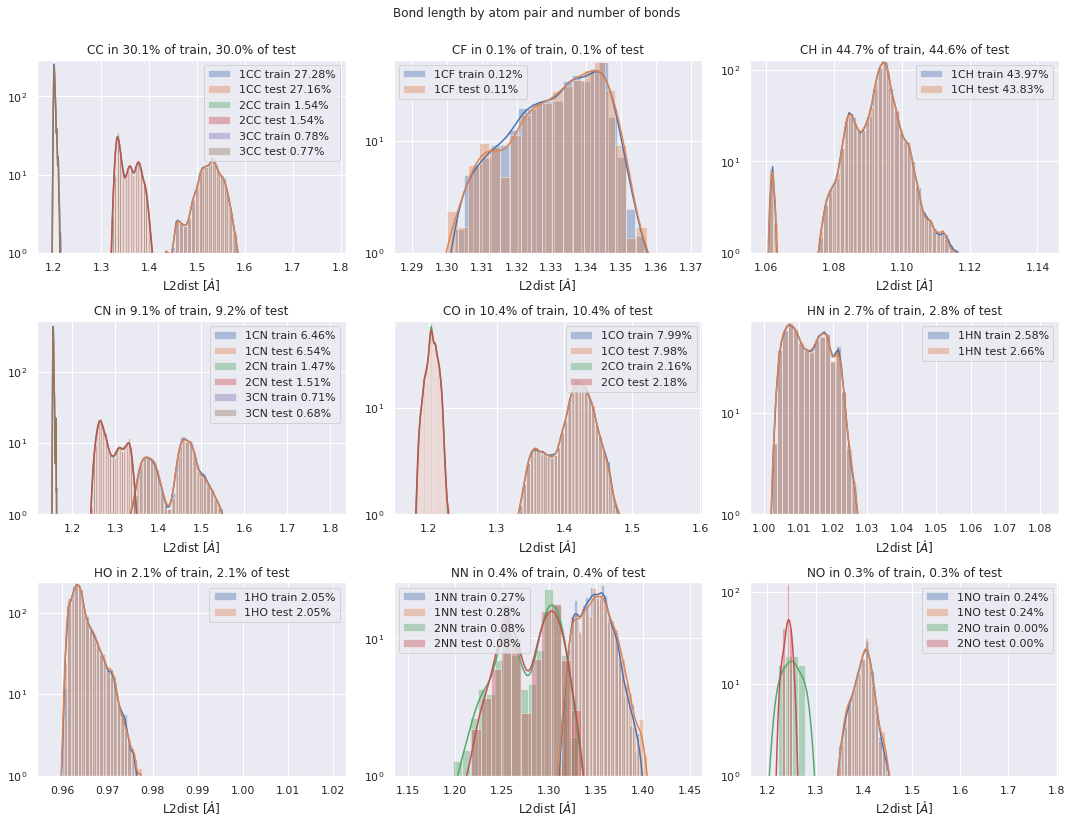

In [11]:
fig = plt.figure(figsize=(15,12))
bond_types = train_bonds.bond_type.unique()
unique_pairs = sorted({t[1:]:1 for t in bond_types}.keys())
for (i, pair) in enumerate(unique_pairs):
    ax = fig.add_subplot(3, 3, i + 1)
    for bond_type in sorted([b for b in bond_types if pair == b[1:]]):
        for (df, name) in [(train_bonds, "train"), (test_bonds, "test")]:
            #errors = df[(df.bond_type == bond_type) & (df.error == 1)].L2dist.values
            #if len(errors) > 0:
            #    sns.distplot(errors, color="red", kde=True)
            selection = df[(df.bond_type == bond_type) & (df.error == 0)].L2dist.values
            sns.distplot(selection, label=f"{bond_type} {name} {len(selection)/len(df)*100:.2f}%", kde=True, ax=ax)
    ax.set_ylim(1, ax.get_ylim()[1])
    ax.set_yscale('log')
    ax.set_xlabel("L2dist $[\mathring{A}]$")
    ratio_tr  = (train_bonds.bond_type.apply(lambda x: x[1:]) == pair).sum() / len(train_bonds)
    ratio_tst = (test_bonds.bond_type.apply(lambda x: x[1:]) == pair).sum() / len(test_bonds)
    ax.set_title(f"{pair} in {ratio_tr*100:.1f}% of train, {ratio_tst*100:.1f}% of test")
    ax.legend()
fig.suptitle("Bond length by atom pair and number of bonds")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


Train and test set does match very well for the relative distribution of bonds length. This is good news as the train and test should behave the same for the prediction of the *scalar coupling constant*.

The number of bond does also build distributions peaking at different bond distance, which is consistent with the expected behaviour: the number of bonds decrease the distance between atoms. The distribution of the `1CC`, `2CC` and `3CC` is a perfect example of very well separated distributions.

However some distributions are bimodal for several bond types. The `1CO` is a good example of this behaviour and should be inspected to check if this is a structural effect or an error of the bond matching algorithm.


## Close analysis of `1CN` double peak in train set



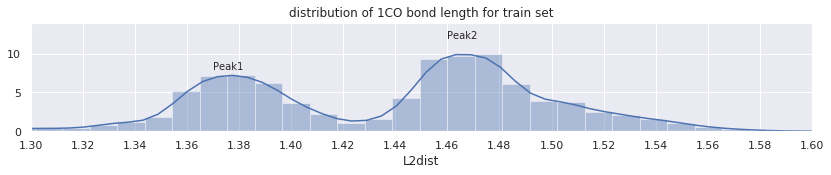

In [12]:
fig = plt.figure( figsize = (14,2) )
selection = train_bonds[(train_bonds.bond_type == '1CN') & (df.error == 0)].L2dist
ax = sns.distplot(selection, label=f"'1CN' {name} {len(selection)/len(df)*100:.2f}%", kde=True)
xticks = plt.xticks(np.linspace(1.3, 1.6, 16))
text = plt.title("distribution of 1CO bond length for train set")
ax.annotate("Peak1", (1.37, 8))
ax.annotate("Peak2", (1.46, 12))
xl = plt.xlim(1.3, 1.6)
yl = plt.ylim(0, 14)

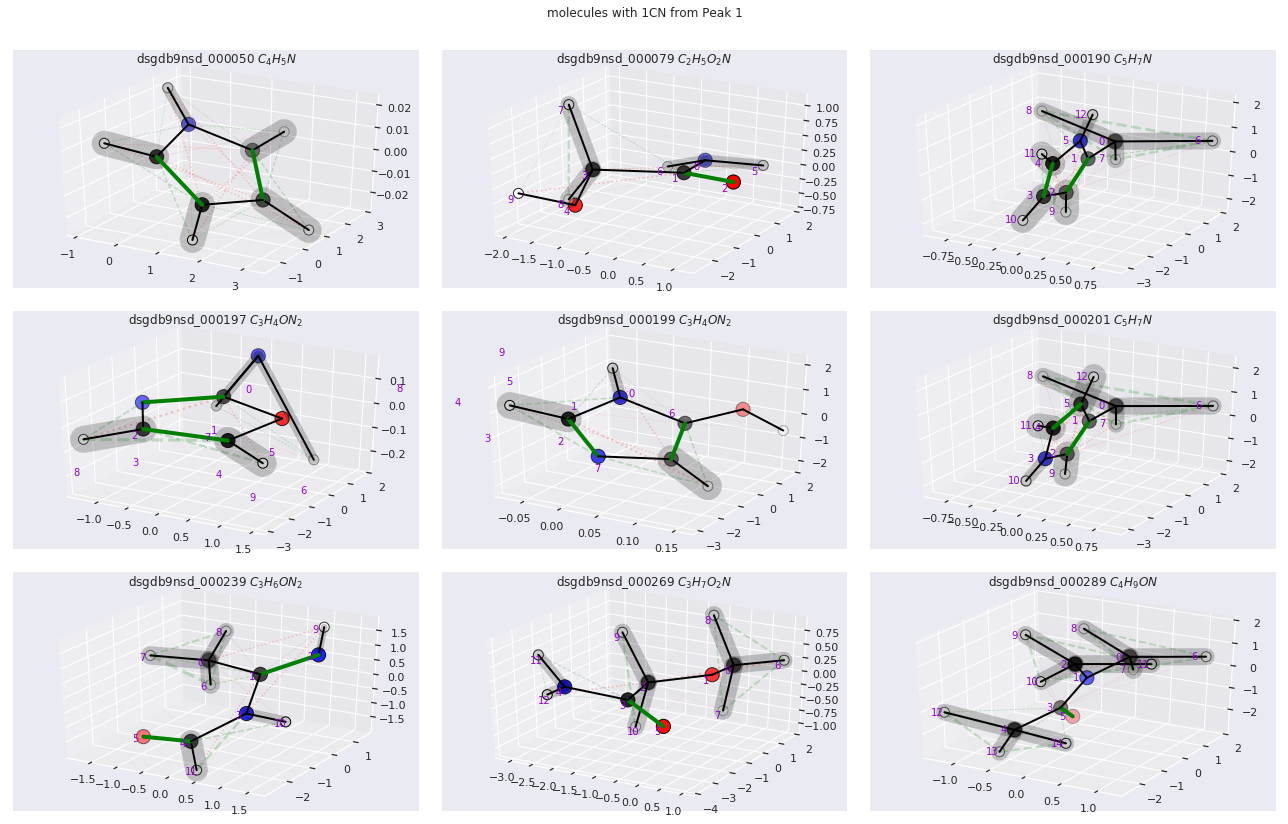

In [13]:
def select_range(df, l0, l1):
    return df[(df.bond_type == '1CN') & (df.error.values == 0) & (df.L2dist.values > l0) & (df.L2dist.values < l1)].molecule_name.unique()
peak1_molecules = select_range(train_bonds, 1.37, 1.375)
peak2_molecules = select_range(train_bonds, 1.465, 1.470)

ncols = 3
nrows = 3
fig1 = plt.figure(figsize = (18, 12))
for i in range(ncols*nrows):
    ax = fig1.add_subplot(nrows, ncols, i + 1, projection="3d")
    plot_molecule(peak1_molecules[i], bonds=train_bonds, ax=ax)
text = fig1.suptitle("molecules with 1CN from Peak 1")
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])

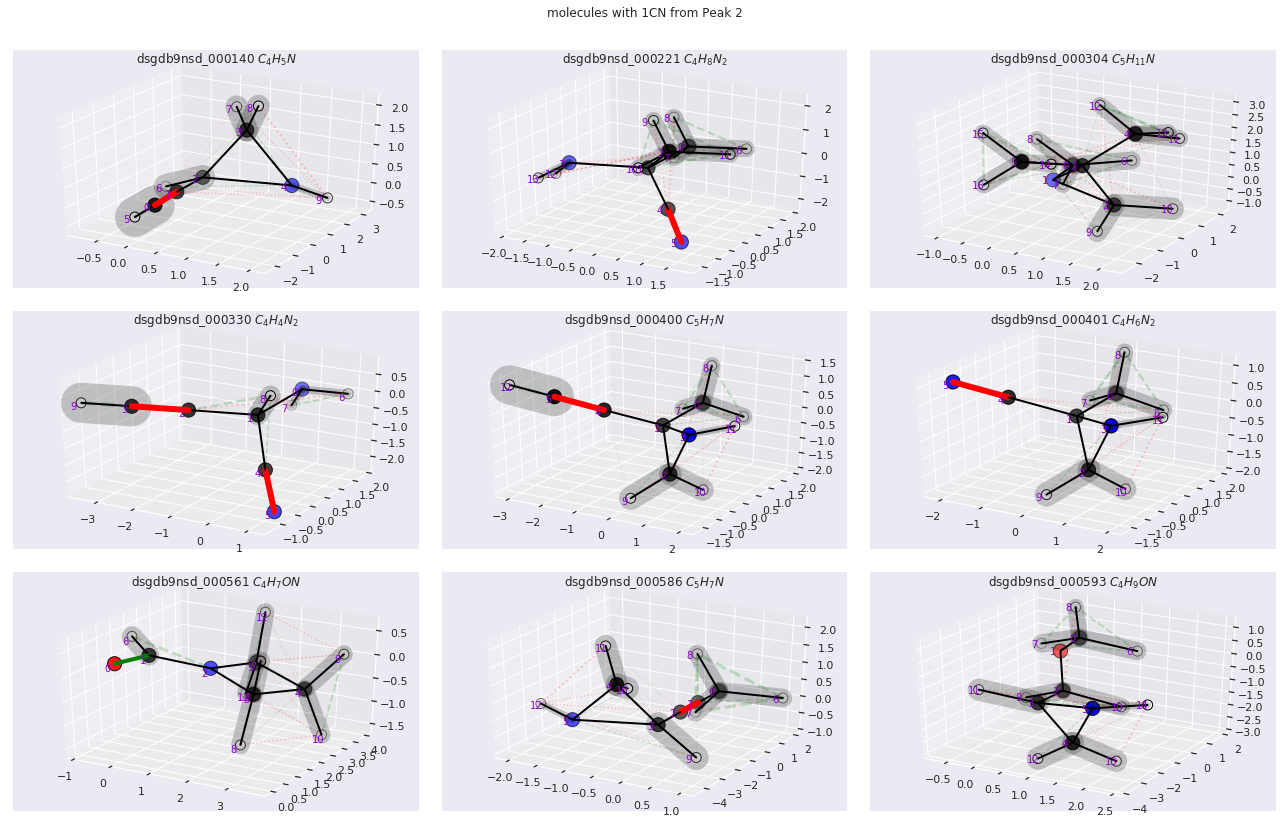

In [14]:
fig2 = plt.figure(figsize = (18, 12))
for i in range(ncols*nrows):
    ax = fig2.add_subplot(nrows, ncols, i + 1, projection="3d")
    plot_molecule(peak2_molecules[i], bonds=train_bonds, ax=ax)
text = fig2.suptitle("molecules with 1CN from Peak 2")
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])

Double bonds are in green, and triple in red, for further details on the visualization see [Training set molecule visualization](https://www.kaggle.com/asauve/training-set-molecule-visualization?scriptVersionId=15133086).

The produced bonding schemes seems healthy for both set of molecules in the selected examples.

Observable differences in the selected set:
* For Peak 1 (shorter bonds): the C containe in the `1CN` is double bonded with another molecule
* For peak 2 (larger bonds): NC bonds are part of a 3 atom CCN cycle.

=> There are strong structural differences in the bonding of the two sets of molecules that may explain the `1CN` bimodal distribution.

These observation could be confirmed on large scale with :
* either a neighbour configuration (easy) selection: how many bonds have the atoms from the pair with which other atoms?
* either a cycle detection code (long)


# Example of molecule with connection failure

The following molecule fails to link all atoms and leaves two atoms with a dangling covalent bond

In [15]:
name = "dsgdb9nsd_000271"
display(structures[structures.molecule_name == name])
display(train_bonds[train_bonds.molecule_name == name])

molecule_name  atom_index atom         x         y         z
2878  dsgdb9nsd_000271           0    N -0.115459  0.959461 -0.041831
2879  dsgdb9nsd_000271           1    H -0.325701 -0.035980  0.058751
2880  dsgdb9nsd_000271           2    H  0.889869  1.042838 -0.203736
2881  dsgdb9nsd_000271           3    H -0.615211  1.317612 -0.861738
2882  dsgdb9nsd_000271           4    C -0.513059  1.675497  1.284742
2883  dsgdb9nsd_000271           5    C  0.163303  1.075910  2.475481
2884  dsgdb9nsd_000271           6    C -0.829484  1.311776  3.767755
2885  dsgdb9nsd_000271           7    O -2.029319  1.341718  3.437503
2886  dsgdb9nsd_000271           8    O -0.229500  1.387702  4.833919
2887  dsgdb9nsd_000271           9    H -0.283736  2.729362  1.114567
2888  dsgdb9nsd_000271          10    H -1.591894  1.527685  1.411585
2889  dsgdb9nsd_000271          11    H  0.226401 -0.017261  2.383165
2890  dsgdb9nsd_000271          12    H  1.159565  1.474860  2.673934

L2dist  atom_index_0  atom_index_1  error     molecule_name  nbond  \
1761  1.022360             0             1      1  dsgdb9nsd_000271      1   
1762  1.021690             0             2      1  dsgdb9nsd_000271      1   
1763  1.024827             0             3      1  dsgdb9nsd_000271      1   
1764  1.091870             4             9      1  dsgdb9nsd_000271      1   
1765  1.096276             4            10      1  dsgdb9nsd_000271      1   
1766  1.098875             5            11      1  dsgdb9nsd_000271      1   
1767  1.091367             5            12      1  dsgdb9nsd_000271      1   
1768  1.244815             6             7      1  dsgdb9nsd_000271      2   
1769  1.225745             6             8      1  dsgdb9nsd_000271      1   
1770  1.494935             4             5      1  dsgdb9nsd_000271      1   
1771  1.646581             5             6      1  dsgdb9nsd_000271      1   

     bond_type  
1761       1HN  
1762       1HN  
1763       1HN  
1764       1CH  
1765       1CH  
1766       1CH  
1767       1CH  
1768       2CO  
1769       1CO  
1770       1CC  
1771       1CC

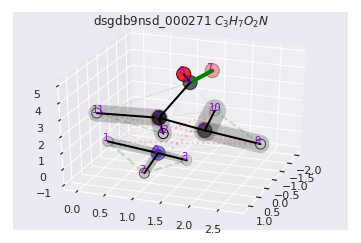

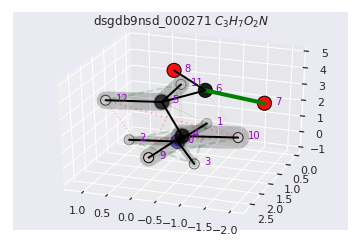

In [16]:
plot_molecule(name, bonds=train_bonds, azim=20, elev=30)
plot_molecule(name, bonds=train_bonds, azim=110, elev=30)


In [17]:
def view3d_molecule(name):
    m = structures[structures.molecule_name == name]
    positions = m[['x','y','z']].values
    # pip install ase
    return ase.visualize.view(Atoms(positions=positions, symbols=m.atom.values), 
                              viewer="x3d") 
view3d_molecule(name)

This molecule correspond most probably to [beta-alanine](https://en.wikipedia.org/wiki/%CE%92-Alanine)  $H_2N-CH_2-CH_2-COOH$ (the two view angle are 90° rotated from each other).

The problem is that the `N` atom should be connected to one `C` instead of three `H`, and one `O` .should have an `H` connected. 
This configuration is curious

Let inspect bond length:

In [18]:
def pairlen(A,B):
    return np.linalg.norm([A.x.values-B.x.values, A.y.values-B.y.values, A.z.values-B.z.values])
m = structures[structures.molecule_name == "dsgdb9nsd_000271"]
N  = m[m.atom_index==0]
C4 = m[m.atom_index==4];   C5 = m[m.atom_index==5]
H1 = m[m.atom_index==1]; H2 = m[m.atom_index==2]; H3 = m[m.atom_index==3]; H10 = m[m.atom_index==10]; H11 = m[m.atom_index==11]
O7 = m[m.atom_index==7]; O8 = m[m.atom_index==8]
print("N-C4=", pairlen(N, C4))
print("N-C5=", pairlen(N, C5))
print("C4-C5", pairlen(C4, C5))
print("N-H1=", pairlen(N, H1))
print("N-H2=", pairlen(N, H2))
print("N-H3=", pairlen(N, H3))
print("C5-H1", pairlen(C5, H1))
print("C4-H3", pairlen(C4, H3))
print("O8-H11", pairlen(O8, H11))
print("O7-H10", pairlen(O7, H10))




N-C4= 1.5590353500168292
N-C5= 2.535376107322178
C4-C5 1.49493522434445
N-H1= 1.0223601271656313
N-H2= 1.0216903141866063
N-H3= 1.0248271259577322
C5-H1 2.7048121910011624
C4-H3 2.1785067413780648
O8-H11 2.8614612755927102
O7-H10 2.0809290902909208


The NH3 bonding seem consistent with the distance to its nearby `H`, but:
* C4 has only 3 covalent bonds
  * N-C4 = 1.56 and is in the upper range of realistic NC bonds : this may be the correct bond
* O8 has only one covalent bond 
  * none of the nearby atom is a candidate for bonding (expected O-H ~ 0.97)

I can't figure out how this could work to build an Alanine isomere from both `O` location.  
Is there a bug in the `structure` for this molecule?

## Distribution of `molecule_name` index

The index contained in the molecule name contains no information about molecule structure AFAIK, but looking at the distribution can provide hints about the train / test split.

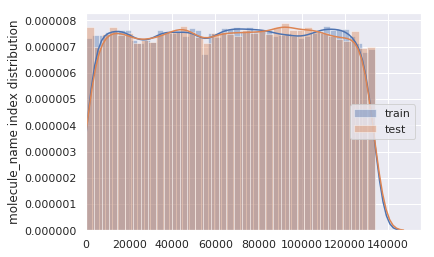

In [19]:
# select molecule index
for df, name in [(train_bonds, "train"), (test_bonds, "test")]:
    index_list = [float(name[10:] ) for name in df.molecule_name.unique() ]
    ax = sns.distplot(index_list, label=f"{name}")
    ax.set_ylabel("molecule_name index distribution")
ax.set_xlim(0, ax.get_xlim()[1])
legend = plt.legend()

Very well: molecule name index is equally distributed among both datasets!

# Write outputs



In [21]:
train_bonds.to_csv('../input/train_bonds.csv')
test_bonds.to_csv('../input/test_bonds.csv')

# What to do next?

* Cycles plays an important role in deshielding of atoms.
The next step would be to build a cycle detection code in order to test new features related to cycles.
* There are issues with some molecules: can a seasonned chemist guess how `dsgdb9nsd_000271` could be bonded correctly?
